In [35]:
filename = "D:/PhD/Data/DFT/NONCOV/DFT_simulations/NMR/Frozen_coords_old/Arg_Pi_charged/orca_out/run_all_displaced_distances.mpi8.out"
n_nuclei = 20

Column labels extracted: ['0 H', '1 C', '2 C', '3 H', '4 C', '5 H']


<Axes: xlabel='Nucleus'>

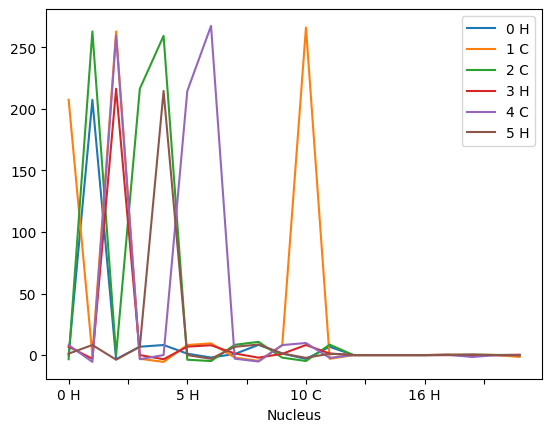

In [40]:
import pandas as pd
import re

def extract_j_coupling(n_nuclei, filename):
    
    column_labels = []
    
    data = []
    
    start_reading = False
    
    row_data = []
    
    rows_to_read = 0
    
    with open(filename, 'r') as file:
        
        for line in file:

            if 'SUMMARY OF ISOTROPIC COUPLING CONSTANTS (Hz)' in line:
                start_reading = True
                continue

            if 'Maximum memory used throughout the entire EPRNMR-calculation:' in line:
                break
            
            if start_reading:

                if not column_labels and re.search(r'\d+ [A-Z]', line):
                    column_labels = re.findall(r'\d+ [A-Z]', line)
                    rows_to_read = n_nuclei
                    print(f"Column labels extracted: {column_labels}")
                    continue
                
                # Accumulate data if we are reading rows
                if rows_to_read > 0:
                    line_parts = line.split()
                    
                    if not line_parts:
                        continue
                    
                    # Detect if this line contains row header and values
                    if len(line_parts) > 2:
                        row_nucleus = line_parts[0] + ' ' + line_parts[1]  # Y-axis nucleus
                        values = line_parts[2:]
                        
                        # Combine current row data with new values
                        if row_data:
                            row_data[1].extend(values)
                        else:
                            row_data = [row_nucleus, values]

                        # Check if we have a complete row
                        if len(row_data[1]) >= len(column_labels):
                            # Extract complete row data
                            row_nucleus = row_data[0]
                            values = row_data[1][:len(column_labels)]
                            
                            # Store row data
                            data.append([row_nucleus] + [float(value) for value in values])
                            
                            # Reset row_data for the next row
                            row_data = []
                            rows_to_read -= 1
                            if rows_to_read == 0:
                                continue
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['Nucleus'] + column_labels)
    df.set_index('Nucleus', inplace=True)

    return df

# Example usage:
df = extract_j_coupling(n_nuclei,filename)

# Print the DataFrame
df

In [1]:
import pandas as pd

columns = ['Molecule', 
                    'Atom', 
                    'x_coord', 
                    'y_coord', 
                    'z_coord', 
                    'sigma_11', 
                    'sigma_22', 
                    'sigma_33', 
                    'dia_sigma_11', 
                    'dia_sigma_22', 
                    'dia_sigma_33', 
                    'para_sigma_11', 
                    'para_sigma_22', 
                    'para_sigma_33', 
                    'sigma_iso', 
                    'nmr_functional', 
                    'nmr_basis_set', 
                    ]
rows = ['benzene_h2o_1', '0H', 0.000, 0.000, 0.000, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 'r2-SCAN 3c', 'def2-mTZVPP']

df = pd.DataFrame([rows], columns=columns)
df


,Molecule,Atom,x_coord,y_coord,z_coord,sigma_11,sigma_22,sigma_33,dia_sigma_11,dia_sigma_22,dia_sigma_33,para_sigma_11,para_sigma_22,para_sigma_33,sigma_iso,nmr_functional,nmr_basis_set
0,benzene_h2o_1,0H,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,r2-SCAN 3c,def2-mTZVPP


In [2]:
columns = ['Molecule', 
                    'Atom_1', 
                    'Atom_2',
                    'x_coord1', 
                    'y_coord1', 
                    'z_coord1', 
                    'x_coord2', 
                    'y_coord2', 
                    'z_coord2',
                    'J_iso',
                    'J_FC_11',
                    'J_FC_22',
                    'J_FC_33',
                    'J_DSO_11',
                    'J_DSO_22',
                    'J_DSO_33',
                    'J_PSO_11',
                    'J_PSO_22',
                    'J_PSO_33',
                    'J_SD_11',
                    'J_SD_22',
                    'J_SD_33',
                    'Mayer_BO' 
                    ]
rows = ['benzene_h2o_1', '0H', '1C', 0.000, 0.000, 0.000, 1.000, 1.000, 1.000, 125.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

df = pd.DataFrame([rows], columns=columns)
df


,Molecule,Atom_1,Atom_2,x_coord1,y_coord1,z_coord1,x_coord2,y_coord2,z_coord2,J_iso,...,J_DSO_11,J_DSO_22,J_DSO_33,J_PSO_11,J_PSO_22,J_PSO_33,J_SD_11,J_SD_22,J_SD_33,Mayer_BO
0,benzene_h2o_1,0H,1C,0.0,0.0,0.0,1.0,1.0,1.0,125.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
    # Search for all the splitted output files from an ORCA calculation in the Machine learning project root directory
    def search_files(self):
        # Iterate through all directories and subdirectories in root for the orca output files
        for root, dirs, files in os.walk(self.root_directory):
            for file in files:
                if file.startswith('splitted_') and file.endswith('.out'): # working with output files is much easier than with full mpi8.out
                    # get the path to those files
                    file_path = os.path.join(root, file)

                    instance_data = self.extract_data_for_ml_database(file_path)
                    
                    # Check if the instance data is not empty (indicating an error)
                    #if instance_data:
                        # Construct DataFrame from the instance data dictionary
                        #instance_df = pd.DataFrame(instance_data)
                        
                        # Append the DataFrame to the main DataFrame
                        #self.df = self.df.append(instance_df, ignore_index=True)
                        
                        # Write to CSV file
                        #self.df.to_csv(self.output_csv_path, index=False)
                    #else:
                        #print(f"No data extracted from file: {file_path}")

        if self.df.empty:
            print("No raw data has been found matching the specified criteria.")


In [3]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [5]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

mol_dir = os.path.join(scratch_dir, 'test_structs/benzene_H2O.xyz')
print(f'Current molecule directory is: {mol_dir}')
mol_dir = OrcaAnalysis().convert_path(mol_dir)

Current work directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\results
Current scratch directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch
Current molecule directory is: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch\test_structs/benzene_H2O.xyz
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz


In [17]:
import os
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

MachineLearning().make_empty_pairwise_prop_df(datasets_dir)

MachineLearning().make_empty_nuc_prop_df(dataset_dir)

nucprop = os.path.join(datasets_dir, 'nuc_prop_nmr_observables.csv')
nucprop_df = pd.read_csv(nucprop)

pw_nucprop = os.path.join(datasets_dir, 'pairwise_nuc_prop_nmr_observables.csv')
pw_nucprop_df = pd.read_csv(pw_nucprop)

Dataset directory is: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch\GenerateMLDataset/data/
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/GenerateMLDataset/data/
The empty pairwise nuclear property dataset has been created and saved in: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/GenerateMLDataset/data/pairwise_nuc_prop_nmr_observables.csv


The empty nuclear property dataset has been created and saved in: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/GenerateMLDataset/data/nuc_prop_nmr_observables.csv




,Molecule,Atom_1,Atom_2,x_coord_1,y_coord_1,z_coord_1,x_coord_2,y_coord_2,z_coord_2,J_iso,...,J_DSO_11,J_DSO_22,J_DSO_33,J_PSO_11,J_PSO_22,J_PSO_33,J_SD_11,J_SD_22,J_SD_33,Mayer_BO


In [18]:
nucprop_df

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_11,sigma_22,sigma_33,dia_sigma_11,dia_sigma_22,dia_sigma_33,para_sigma_11,para_sigma_22,para_sigma_33,nmr_functional,nmr_basis_set


In [19]:
pw_nucprop_df

,Molecule,Atom_1,Atom_2,x_coord_1,y_coord_1,z_coord_1,x_coord_2,y_coord_2,z_coord_2,J_iso,...,J_DSO_11,J_DSO_22,J_DSO_33,J_PSO_11,J_PSO_22,J_PSO_33,J_SD_11,J_SD_22,J_SD_33,Mayer_BO
